# Experimento: Clasificación de asuntos mediante reglas y palabras clave

## Descripción general

En esta notebook se implementa y evalúa un enfoque heurístico para la
clasificación automática de asuntos administrativos, basado en la detección
de palabras clave asociadas a cada área.

Este experimento constituye un **baseline inicial**, utilizado para comprender
la estructura del problema y establecer un punto de comparación frente a
enfoques más complejos.

---

## Objetivo del experimento

- Explorar un método simple y transparente para la clasificación de asuntos.
- Definir conjuntos de palabras clave representativas de cada área administrativa.
- Evaluar el desempeño del enfoque ante redacciones típicas y casos ambiguos.
- Identificar limitaciones del método heurístico.

---

## Enfoque metodológico

- Se construyen diccionarios de palabras clave por área.
- Cada asunto se analiza buscando coincidencias con dichos diccionarios.
- La asignación de área se realiza según reglas de prioridad y cantidad de coincidencias.
- No se utiliza aprendizaje automático ni entrenamiento supervisado.

---

## Resultados y observaciones

El enfoque basado en palabras clave presenta las siguientes características:

- Ventajas:
  - Alta interpretabilidad.
  - Fácil implementación.
  - Bajo costo computacional.

- Limitaciones:
  - Sensibilidad a la redacción exacta del asunto.
  - Dificultad para generalizar a nuevos términos.
  - Resultados inconsistentes en casos ambiguos o poco estructurados.

---

## Rol dentro del proyecto

Este experimento permitió:

- Comprender el dominio del problema.
- Establecer un baseline de referencia.
- Justificar la necesidad de explorar enfoques más robustos.

Los resultados obtenidos sirvieron como punto de comparación para los métodos
basados en Machine Learning y modelos de lenguaje.


In [ ]:
import pandas as pd

In [ ]:
# 1) Cargar tus datos (id, asunto, cuerpo, area_destino)
df = pd.read_csv("/content/drive/MyDrive/Diplo-2025/Proyecto/24 11 Proyecto/Dataset_24-11.csv")  # ← arma este CSV

In [ ]:
df.head()

,Fecha de creación,Asunto,AREA OBJETIVO
0,8/9/2025,ADJUNTAR DOCUMENTACIÓN SOLICITADA,MESA DE ENTRADAS
1,8/9/2025,CAMBIO DE TITULARIDAD PARA ADJUDICATARIOS,REGULARIZACION DOMINIAL
2,8/9/2025,CANCELACION DE HIPOTECA,GESTION FINANCIERA
3,8/9/2025,COMBUSTIBLE PARA VEHICULOS OFICIALES - PETROLE...,ADMINISTRACION
4,8/9/2025,CUPON DE PAGO - CAMBIO DE TITULARIDAD,REGULARIZACION DOMINIAL/GESTION FINANCIERA


In [ ]:
df = df.rename(columns={
    "Asunto": "asunto",
    "AREA OBJETIVO": "area_objetivo"
})

df["area_objetivo"] = df["area_objetivo"].astype(str).str.strip()
df["asunto"] = df["asunto"].astype(str).str.strip()


In [ ]:
df["asunto"] = df["asunto"].str.lower().str.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8')

In [ ]:
df.describe(include='O')

,Fecha de creación,asunto,area_objetivo
count,756,756,756
unique,47,543,10
top,9/9/2025,"solicitud de cuotas, cancelacion y libre de de...",REGULARIZACION DOMINIAL
freq,38,58,253


In [ ]:
df['area_objetivo'] = df['area_objetivo'].str.strip()
print("Value counts after stripping whitespace:")
df['area_objetivo'].value_counts()

Value counts after stripping whitespace:


,count
area_objetivo,
REGULARIZACION DOMINIAL,253
GESTION FINANCIERA,211
ESCRITURACIONES,150
MESA DE ENTRADAS,56
ADMINISTRACION,54
REGULARIZACION DOMINIAL/GESTION FINANCIERA,12
JURIDICO,8
REGULARIZACION DOMINIAL/ESCRITURACIONES,5
TECNICA,4


In [ ]:
df['area_objetivo'] = df['area_objetivo'].replace('GESTION FINANCIERA/ESCRITURACIONES', 'GESTION FINANCIERA')

df['area_objetivo'] = df['area_objetivo'].replace(['REGULARIZACION DOMINIAL/GESTION FINANCIERA', 'REGULARIZACION DOMINIAL/ESCRITURACIONES'], 'REGULARIZACION DOMINIAL')

df['area_objetivo'].value_counts()

,count
area_objetivo,
REGULARIZACION DOMINIAL,270
GESTION FINANCIERA,214
ESCRITURACIONES,150
MESA DE ENTRADAS,56
ADMINISTRACION,54
JURIDICO,8
TECNICA,4


In [ ]:
conteo_area = df["area_objetivo"].value_counts()
porcentaje_area = df["area_objetivo"].value_counts(normalize=True) * 100

dist_areas = pd.DataFrame({
    "registros": conteo_area,
    "porcentaje": porcentaje_area.round(2)
})

dist_areas


,registros,porcentaje
area_objetivo,,
REGULARIZACION DOMINIAL,270,35.71
GESTION FINANCIERA,214,28.31
ESCRITURACIONES,150,19.84
MESA DE ENTRADAS,56,7.41
ADMINISTRACION,54,7.14
JURIDICO,8,1.06
TECNICA,4,0.53


In [ ]:
# 1) Duplicados 100% idénticos (asunto + área + palabra)
df["es_dup_exacto"] = df.duplicated(
    subset=["asunto", "area_objetivo"],
    keep=False  # marca todos los que estén en grupos duplicados
)

# 2) Duplicados por asunto dentro de la misma área
df["es_dup_asunto_en_area"] = df.duplicated(
    subset=["asunto", "area_objetivo"],
    keep=False
)


Esto ya te responde cosas como:

“En el área X, el 60% de los registros pertenecen a asuntos repetidos”

“El área Y tiene pocos asuntos, pero muy repetidos”

In [ ]:
print(f"Number of duplicate rows in df: {df.duplicated(subset=['asunto']).sum()}")

Number of duplicate rows in df: 213


In [ ]:
print(f"Number of duplicate rows in df_filtered: {df.duplicated(subset=['asunto']).sum()}")
if df.duplicated().sum() > 0:
    print("Duplicate rows:")
    print(df[df.duplicated(subset=['asunto'],keep=False)].sort_values(by='asunto'))
else:
    print("No duplicate rows found.")

Number of duplicate rows in df_filtered: 213
Duplicate rows:
    Fecha de creación                                             asunto  \
732        29/07/2025                         actualizar cedulon vencido   
456        10/07/2025                         actualizar cedulon vencido   
719        28/07/2025  adelantamiento de cuotas de planes provinciale...   
407        06/07/2025  adelantamiento de cuotas de planes provinciale...   
118         12/9/2025  adelantamiento de cuotas de planes provinciale...   
..                ...                                                ...   
243         19/9/2025  suministro de gas natural - distribuidora de g...   
481        11/07/2025  suministro de gas natural - distribuidora de g...   
620        21/07/2025                                           vivienda   
244         19/9/2025                                           vivienda   
68           9/9/2025                                           vivienda   

          area_objetivo  e

In [ ]:
df.shape

(756, 5)

In [ ]:
df = df.drop_duplicates(subset=['asunto'])
df.shape

(543, 5)

In [ ]:
df['area_objetivo_codificada'], _ = pd.factorize(df['area_objetivo'])

In [ ]:
df

,Fecha de creación,asunto,area_objetivo,es_dup_exacto,es_dup_asunto_en_area,area_objetivo_codificada
0,8/9/2025,adjuntar documentacion solicitada,MESA DE ENTRADAS,True,True,0
1,8/9/2025,cambio de titularidad para adjudicatarios,REGULARIZACION DOMINIAL,True,True,1
2,8/9/2025,cancelacion de hipoteca,GESTION FINANCIERA,True,True,2
3,8/9/2025,combustible para vehiculos oficiales - petrole...,ADMINISTRACION,False,False,3
4,8/9/2025,cupon de pago - cambio de titularidad,REGULARIZACION DOMINIAL,False,False,1
...,...,...,...,...,...,...
751,31/07/2025,turno escritura,ESCRITURACIONES,False,False,4
752,31/07/2025,escritura de mi terreno segundo testimonio,ESCRITURACIONES,False,False,4
753,31/07/2025,ponerme al dia con mi deuda,GESTION FINANCIERA,False,False,2
754,31/07/2025,direccion de vivienda - solicita inscripcion d...,REGULARIZACION DOMINIAL,False,False,1


In [ ]:
area_mapping = dict(zip(df['area_objetivo'], df['area_objetivo_codificada']))
print("Mapping of 'AREA OBJETIVO' to Numerical Codes:")
print(area_mapping)

Mapping of 'AREA OBJETIVO' to Numerical Codes:
{'MESA DE ENTRADAS': 0, 'REGULARIZACION DOMINIAL': 1, 'GESTION FINANCIERA': 2, 'ADMINISTRACION': 3, 'ESCRITURACIONES': 4, 'JURIDICO': 5, 'TECNICA': 6}


# Palabras Clave por Area

In [ ]:
keywords_por_area = {
    "MESA DE ENTRADAS": [
        "archivo",
        "desarchivo",
    ],
    "ADMINISTRACION": [
        "aguas cordobesas",
        "combustible",
        "libreria",
        "materiales",
        "presupuesto",
        "presupuestaria",
        "gas del centro",
        "honorarios",
        "medico",
        "telecom",
        "epec",
        "tribunal de cuentas",
        "auditoria",
        "cupo",
        "factura",
        "facturacion",
    ],
    "GESTION FINANCIERA": [
        "cuota",
        "cupon",
        "pago",
        "pagar",
        "cedulon",
        "cancelacion",
        "cancelar",
        "libre de deuda",
        "deuda",
        "compensacion de cuota",
        "debito",
        "debito automatico",
        "medios de pago",
        "adelantar",
    ],
    "TECNICA": [
        "planos",
        "depreciacion",
        "valuacion",
        "deterioro",
        "agrimensor",
        "construccion",
        "certificado de obra",
        "remodelacion",
    ],
    "REGULARIZACION DOMINIAL": [
        "adjudicacion",
        "adjudicaciones",
        "readjudicacion",
        "regularizacion",
        "regularizacion de deuda",
        "regularizacion de pago",
        "deshabitada",
        "abandonada",
        "abandono",
        "desocupada",
        "adquisicion",
        "contrato",
        "plan de pago",
        "plan de cuotas",
        "refinanciacion",
        "refinanciar",
        "refinanciar deuda",
        "refinanciacion de deuda",
        "permuta",
        "financiacion",
        "titularidad",
        "compra",
        "comprar",
        "venta",
        "vender",
        "restitucion",
    ],
    "JURIDICO": [
        "pronto despacho",
        "juicio",
        "carta documento",
        "juzgado",
        "justicia",
        "amparo",
        "recurso de reconsideracion",
    ],
    "ESCRITURACIONES": [
        "escritura",
        "escrituracion",
        "venta con hipoteca",
        "escribano",
    ],
}


In [ ]:
df.columns

Index(['Fecha de creación', 'asunto', 'area_objetivo', 'es_dup_exacto',
       'es_dup_asunto_en_area', 'area_objetivo_codificada'],
      dtype='object')

In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.1 MB/s eta 0:00:00


In [ ]:
import re
from unidecode import unidecode  # pip install unidecode

def normalizar_texto(texto: str) -> str:
    texto = texto.lower()
    texto = unidecode(texto)   # quita tildes: “escritura” -> “escritura”
    return texto


In [ ]:
def contar_coincidencias(texto_norm, palabras_clave):
    conteo = 0
    for kw in palabras_clave:
        patron = r"\b" + re.escape(kw) + r"\b"
        hits = re.findall(patron, texto_norm)
        conteo += len(hits)
    return conteo


In [ ]:
def clasificar_por_keywords(texto, keywords_por_area, umbral=1):
    texto_norm = normalizar_texto(texto if isinstance(texto, str) else "")

    puntajes = {}
    for area, palabras in keywords_por_area.items():
        puntajes[area] = contar_coincidencias(texto_norm, palabras)

    # área con mayor puntaje
    area_mejor, score_mejor = max(puntajes.items(), key=lambda x: x[1])

    # si no llega al umbral, no la clasificamos
    if score_mejor < umbral:
        return "Sin clasificar"
    return area_mejor


In [ ]:
df["area_kw"] = df["asunto"].apply(
    lambda x: clasificar_por_keywords(x, keywords_por_area, umbral=1)
)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(df["area_objetivo"], df["area_kw"]))
print(confusion_matrix(df["area_objetivo"], df["area_kw"]))


                         precision    recall  f1-score   support

         ADMINISTRACION       1.00      0.76      0.86        42
        ESCRITURACIONES       0.98      0.69      0.81        75
     GESTION FINANCIERA       0.84      0.88      0.86       152
               JURIDICO       1.00      0.75      0.86         8
       MESA DE ENTRADAS       0.60      0.06      0.11        51
REGULARIZACION DOMINIAL       0.99      0.74      0.85       211
         Sin clasificar       0.00      0.00      0.00         0
                TECNICA       1.00      0.75      0.86         4

               accuracy                           0.71       543
              macro avg       0.80      0.58      0.65       543
           weighted avg       0.91      0.71      0.78       543

[[ 32   1   0   0   1   1   7   0]
 [  0  52   3   0   0   1  19   0]
 [  0   0 133   0   0   0  19   0]
 [  0   0   0   6   0   0   2   0]
 [  0   0   0   0   3   0  48   0]
 [  0   0  22   0   1 157  31   0]
 [  0  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
reverse_mapping = {v: k for k, v in area_mapping.items()}


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
df.columns

Index(['Fecha de creación', 'asunto', 'area_objetivo', 'es_dup_exacto',
       'es_dup_asunto_en_area', 'area_objetivo_codificada', 'area_kw'],
      dtype='object')

In [ ]:
y_true = df["area_objetivo"]
y_pred = df["area_kw"]

In [ ]:
y_true.shape

(543,)

In [ ]:
y_pred.shape

(543,)

In [ ]:
y_true.value_counts()

,count
area_objetivo,
REGULARIZACION DOMINIAL,211
GESTION FINANCIERA,152
ESCRITURACIONES,75
MESA DE ENTRADAS,51
ADMINISTRACION,42
JURIDICO,8
TECNICA,4


In [ ]:
y_pred.value_counts()

,count
area_kw,
REGULARIZACION DOMINIAL,159
GESTION FINANCIERA,158
Sin clasificar,127
ESCRITURACIONES,53
ADMINISTRACION,32
JURIDICO,6
MESA DE ENTRADAS,5
TECNICA,3


In [ ]:
y_pred

,area_kw
0,Sin clasificar
1,REGULARIZACION DOMINIAL
2,GESTION FINANCIERA
3,ADMINISTRACION
4,GESTION FINANCIERA
...,...
751,ESCRITURACIONES
752,ESCRITURACIONES
753,GESTION FINANCIERA
754,REGULARIZACION DOMINIAL


In [ ]:
df[df["area_kw"] == "Sin clasificar"]

,Fecha de creación,asunto,area_objetivo,es_dup_exacto,es_dup_asunto_en_area,area_objetivo_codificada,area_kw
0,8/9/2025,adjuntar documentacion solicitada,MESA DE ENTRADAS,True,True,0,Sin clasificar
24,8/9/2025,solicitud de documentacion pedida,MESA DE ENTRADAS,False,False,0,Sin clasificar
30,8/9/2025,solicitud terreno,MESA DE ENTRADAS,False,False,0,Sin clasificar
31,9/9/2025,area control de adjuducaciones tramite gobdig...,REGULARIZACION DOMINIAL,False,False,1,Sin clasificar
37,9/9/2025,cumplimento notificacion en tramite sticker 10...,MESA DE ENTRADAS,False,False,0,Sin clasificar
...,...,...,...,...,...,...,...
733,29/07/2025,reclamo cuotas no imputadas,GESTION FINANCIERA,False,False,2,Sin clasificar
737,29/07/2025,cuando se va a poder escriturar mi vivienda?????,ESCRITURACIONES,False,False,4,Sin clasificar
747,31/07/2025,ref muneracion 90490,MESA DE ENTRADAS,False,False,0,Sin clasificar
748,31/07/2025,nuevamente me figura archivado tramite de camb...,REGULARIZACION DOMINIAL,False,False,1,Sin clasificar


In [ ]:
labels = sorted(df["area_objetivo"].unique())

cm = confusion_matrix(y_true, y_pred, labels=labels)


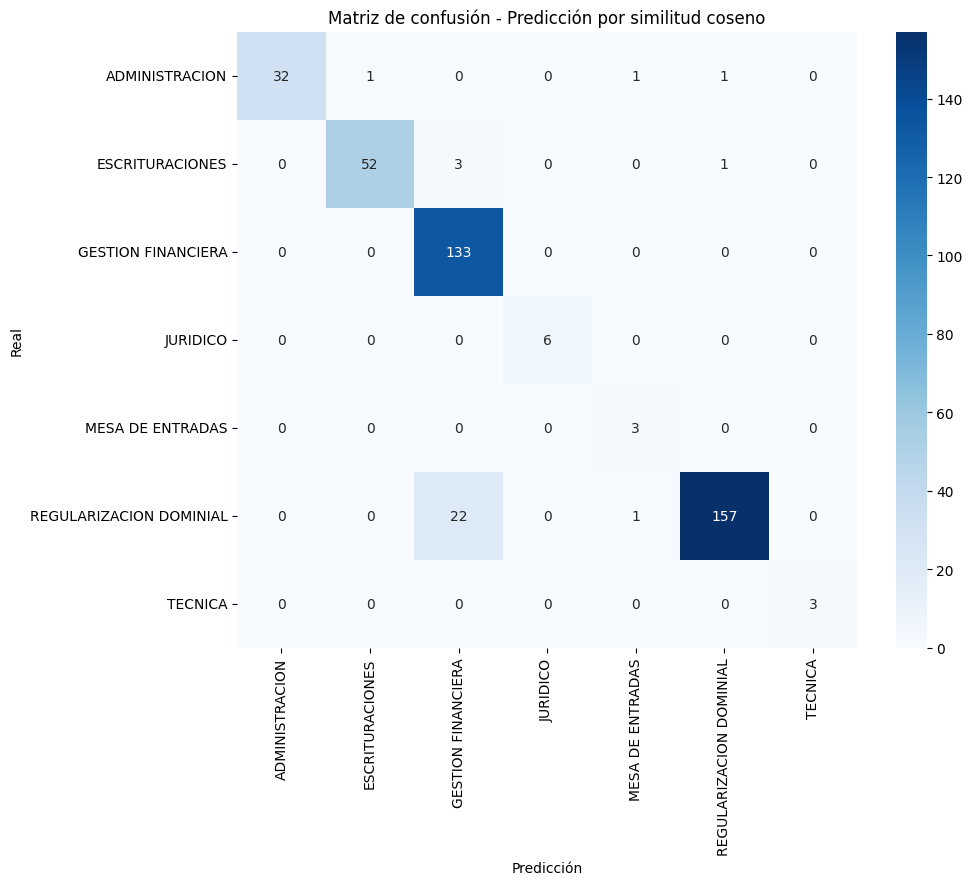

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - Predicción por similitud coseno")
plt.show()


In [ ]:
clasificados_por_area = df["area_kw"].value_counts().rename("clasificados")


In [ ]:
df["error"] = df["area_kw"] != df["area_objetivo"]


In [ ]:
errores_por_area = df.groupby("area_kw")["error"].sum().rename("errores")

In [ ]:
tabla_resultados = pd.concat([clasificados_por_area, errores_por_area], axis=1)
tabla_resultados

,clasificados,errores
area_kw,,
REGULARIZACION DOMINIAL,159,2
GESTION FINANCIERA,158,25
Sin clasificar,127,127
ESCRITURACIONES,53,1
ADMINISTRACION,32,0
JURIDICO,6,0
MESA DE ENTRADAS,5,2
TECNICA,3,0


In [ ]:
df_errores = df[df["area_kw"] != df["area_objetivo"]]

In [ ]:
errores_por_area_real = (
    df_errores
    .groupby("area_objetivo")
    .size()
    .rename("errores")
)
errores_por_area_real


,errores
area_objetivo,
ADMINISTRACION,10
ESCRITURACIONES,23
GESTION FINANCIERA,19
JURIDICO,2
MESA DE ENTRADAS,48
REGULARIZACION DOMINIAL,54
TECNICA,1


In [ ]:
# df_errores[df_errores["area_objetivo"] == "REGULARIZACION DOMINIAL"][["asunto", "area_kw", "area_objetivo"]]

# Guardamos los resultados

In [ ]:
import os
import json
from datetime import datetime

def crear_carpeta_experimento(nombre_base="experimento"):
    fecha = datetime.now().strftime("%Y%m%d_%H%M%S")
    carpeta = f"/content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/{nombre_base}_{fecha}"
    os.makedirs(carpeta, exist_ok=True)
    return carpeta


def guardar_resultados(carpeta_experimento, df_resultados, nombre_archivo="resultados.csv"):
    ruta = os.path.join(carpeta_experimento, nombre_archivo)
    df_resultados.to_csv(ruta, index=False, encoding="utf-8")
    print(f"✔ Resultados guardados en: {ruta}")


def guardar_metricas(carpeta_experimento, accuracy, clas_report, parametros, descripcion):
    metricas = {
        "accuracy": accuracy,
        "classification_report": clas_report,
        "parametros_modelo": parametros,
        "descripcion": descripcion,
    }

    ruta = os.path.join(carpeta_experimento, "metricas.json")
    with open(ruta, "w", encoding="utf-8") as f:
        json.dump(metricas, f, indent=4, ensure_ascii=False)

    print(f"✔ Métricas guardadas en: {ruta}")


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Nombre "modelo" de este experimento
modelo = "Reglas_PalabrasClave_v1"

# === 1. Crear carpeta del experimento ===
carpeta = crear_carpeta_experimento("experimento_Reglas_PalabrasClave")


# === 2. Marcar errores y armar resumen por área ===

# error = 1 si la predicción por palabras clave no coincide con el área real
df["error"] = df["area_kw"] != df["area_objetivo"]

# resumen por área (según área predicha)
resumen_areas = (
    df
    .groupby("area_kw")
    .agg(
        clasificados=("area_kw", "size"),
        errores=("error", "sum"),
    )
)

resumen_areas["porcentaje_error"] = (
    resumen_areas["errores"] / resumen_areas["clasificados"] * 100
).round(2)


# === 3. Guardar resultados completos y resumen ===

# todas las filas con area_real, area_kw, error, etc.
guardar_resultados(carpeta, df, nombre_archivo="resultados_completos.csv")

# tabla resumen por área
guardar_resultados(carpeta, resumen_areas.reset_index(), nombre_archivo="resumen_por_area.csv")


# === 4. Calcular métricas globales ===

y_true = df["area_objetivo"]
y_pred = df["area_kw"]

accuracy = accuracy_score(y_true, y_pred)
clas_report_text = classification_report(y_true, y_pred)


# === 5. Metadatos del experimento ===

parametros_modelo = {
    "tipo": "clasificador_reglas_palabras_clave",
    "descripcion": "Clasificador basado en conteo de palabras clave por área",
    "modelo": modelo,
    "estrategia": "Coincidencias de palabras clave + selección de área con mayor puntaje",
    "top_k": "no aplica",
    "umbral_minimo_coincidencias": 1,
    "cantidad_asuntos": int(len(df)),
    "cantidad_areas_reales": int(df["area_objetivo"].nunique()),
    "cantidad_areas_predichas": int(df["area_kw"].nunique()),
    "sin_clasificar": int(df[df["area_kw"] == "Sin clasificar"].shape[0]),
}

descripcion = f"""
Experimento de clasificación de asuntos utilizando reglas de palabras clave.

Modelo:
- {modelo}

Estrategia:
- Normalizar texto (minúsculas, sin tildes).
- Contar coincidencias de palabras clave por área.
- Asignar el área con mayor cantidad de coincidencias si supera el umbral mínimo.
- En caso contrario, clasificar como 'Sin clasificar' (si usás esa categoría).

Datos:
- Total de asuntos: {len(df)}
- Áreas reales (ground truth): {df['area_objetivo'].nunique()}
- Áreas predichas: {df['area_kw'].nunique()}
"""


# === 6. Guardar métricas ===

guardar_metricas(
    carpeta,
    accuracy,
    clas_report_text,
    parametros_modelo,
    descripcion
)

print("\n✔ El experimento se guardó correctamente en:")
print(carpeta)


✔ Resultados guardados en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_Reglas_PalabrasClave_20251209_044913/resultados_completos.csv
✔ Resultados guardados en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_Reglas_PalabrasClave_20251209_044913/resumen_por_area.csv
✔ Métricas guardadas en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_Reglas_PalabrasClave_20251209_044913/metricas.json

✔ El experimento se guardó correctamente en:
/content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_Reglas_PalabrasClave_20251209_044913


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Palabras claves con orden de prioridad en Areas

In [ ]:
orden_areas = [
    "REGULARIZACION DOMINIAL",
    "GESTION FINANCIERA",
    "ESCRITURACIONES",
    "MESA DE ENTRADAS",
    "ADMINISTRACION",
    "TECNICA",
    "JURIDICO",
]


In [ ]:
import re
from unidecode import unidecode  # si no lo tenés: pip install unidecode

def normalizar_texto(texto: str) -> str:
    if not isinstance(texto, str):
        texto = ""
    texto = texto.lower()
    texto = unidecode(texto)
    return texto

def area_por_prioridad(texto, keywords_por_area, orden_areas):
    texto_norm = normalizar_texto(texto)

    for area in orden_areas:
        palabras = keywords_por_area.get(area, [])
        for kw in palabras:
            # palabra/frase completa, sin distinguir mayúsculas/minúsculas
            patron = r"\b" + re.escape(kw) + r"\b"
            if re.search(patron, texto_norm):
                return area  # apenas encuentra una, corta y devuelve el área prioritario

    # si ninguna área matchea:
    return "Sin clasificar"


In [ ]:
df["area_kw_prioridad"] = df["asunto"].apply(
    lambda x: area_por_prioridad(x, keywords_por_area, orden_areas)
)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

modelo = "Reglas_PalabrasClave_Prioridad_v1"

# 1. Crear carpeta del experimento
carpeta = crear_carpeta_experimento("experimento_PalabrasClave_Prioridad")


# 2. Marcar errores y resumen por área (usando la nueva columna)
df["error_prioridad"] = df["area_kw_prioridad"] != df["area_objetivo"]

resumen_areas_prioridad = (
    df
    .groupby("area_kw_prioridad")
    .agg(
        clasificados=("area_kw_prioridad", "size"),
        errores=("error_prioridad", "sum"),
    )
)

resumen_areas_prioridad["porcentaje_error"] = (
    resumen_areas_prioridad["errores"] / resumen_areas_prioridad["clasificados"] * 100
).round(2)


# 3. Guardar resultados
guardar_resultados(carpeta, df, nombre_archivo="resultados_completos_prioridad.csv")
guardar_resultados(
    carpeta,
    resumen_areas_prioridad.reset_index(),
    nombre_archivo="resumen_por_area_prioridad.csv"
)


# 4. Métricas globales
y_true = df["area_objetivo"]
y_pred = df["area_kw_prioridad"]

accuracy = accuracy_score(y_true, y_pred)
clas_report_text = classification_report(y_true, y_pred)


# 5. Metadatos del experimento
parametros_modelo = {
    "tipo": "clasificador_reglas_palabras_clave_prioridad",
    "descripcion": "Clasificador basado en palabras clave con orden de prioridad por área",
    "modelo": modelo,
    "estrategia": (
        "Recorrido secuencial de áreas en orden de importancia. "
        "Se asigna la primera área cuyo conjunto de palabras clave aparece en el asunto. "
        "Si no hay coincidencias, se asigna 'Sin clasificar'."
    ),
    "orden_areas": orden_areas,
    "cantidad_asuntos": int(len(df)),
    "cantidad_areas_reales": int(df["area_objetivo"].nunique()),
    "cantidad_areas_predichas": int(df["area_kw_prioridad"].nunique()),
    "sin_clasificar": int(df[df["area_kw_prioridad"] == "Sin clasificar"].shape[0]),
}

descripcion = f"""
Experimento de clasificación de asuntos utilizando reglas de palabras clave con prioridad por área.

Modelo:
- {modelo}

Estrategia:
- Normalizar texto (minúsculas, sin tildes).
- Recorrer las áreas en el siguiente orden de prioridad:
  {orden_areas}
- Para cada área, buscar coincidencias de palabras/frases clave.
- La primera área con al menos una coincidencia se asigna como predicción.
- Si ninguna área tiene coincidencias, se asigna 'Sin clasificar'.

Datos:
- Total de asuntos: {len(df)}
- Áreas reales (ground truth): {df['area_objetivo'].nunique()}
- Áreas predichas: {df['area_kw_prioridad'].nunique()}
"""


# 6. Guardar métricas
guardar_metricas(
    carpeta,
    accuracy,
    clas_report_text,
    parametros_modelo,
    descripcion
)

print("\n✔ El experimento de prioridad se guardó correctamente en:")
print(carpeta)


✔ Resultados guardados en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_PalabrasClave_Prioridad_20251209_050811/resultados_completos_prioridad.csv
✔ Resultados guardados en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_PalabrasClave_Prioridad_20251209_050811/resumen_por_area_prioridad.csv
✔ Métricas guardadas en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_PalabrasClave_Prioridad_20251209_050811/metricas.json

✔ El experimento de prioridad se guardó correctamente en:
/content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_PalabrasClave_Prioridad_20251209_050811


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
